# Marketing Campaign A/B Testing Analysis

## Step 1 - Understand the Business Problem

The first crucial step in A/B testing is to understand the business problem. A vital aspect in understanding the business problem is exploring the data. Using Pandas and visualization libraries, we will create tables and plots to make sense of the data.

### Business Context
A company wants to optimize their digital marketing campaigns to improve customer acquisition and return on ad spend (ROAS). They are comparing two different campaign strategies:

- **Control Campaign**: The existing marketing approach
- **Test Campaign**: A new experimental marketing strategy with different targeting, creative, or budget allocation

### Key Business Questions
1. Which campaign drives more purchases at a lower cost?
2. Which campaign has better conversion rates throughout the marketing funnel?
3. What is the statistical significance of the performance difference?
4. Should the company scale the Test Campaign or stick with the Control Campaign?

### Dataset Overview
- **Time Period**: August 1-30, 2019 (30 days)
- **Campaigns**: Control vs Test Campaign
- **Daily Metrics**: Spend, impressions, reach, clicks, searches, content views, cart additions, purchases

### Success Metrics
- **Primary**: Conversion Rate (Purchases ÷ Impressions)
- **Secondary**: Cost per Purchase, Click-through Rate
- **Business Impact**: Total purchases, Return on Ad Spend (ROAS)

This analysis will provide data-driven recommendations for the marketing team's strategic decision on campaign implementation.

In [47]:
from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 123
np.random.seed(SEED)

## Load Data

In [2]:
# Load Data with correct separator
control_df = pd.read_csv('data/control_group.csv', sep=';')
test_df = pd.read_csv('data/test_group.csv', sep=';')

In [3]:
control_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Control Campaign Data:")
print(f"Shape: {control_df.shape}")
print("Columns:", control_df.columns.tolist())

Control Campaign Data:
Shape: (30, 10)
Columns: ['Campaign Name', 'Date', 'Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [5]:
control_df.head()


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("\nTest Campaign Data:")
print(f"Shape: {test_df.shape}")
print("Columns:", test_df.columns.tolist())


Test Campaign Data:
Shape: (30, 10)
Columns: ['Campaign Name', 'Date', 'Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [7]:
test_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [8]:
# Clean column names for easier handling
def clean_column_names(df):
    df.columns = df.columns.str.replace('# of ', 'num_')
    df.columns = df.columns.str.replace(' [USD]', '_usd') 
    df.columns = df.columns.str.replace(' ', '_')
    return df

In [9]:
control_df = clean_column_names(control_df)
test_df = clean_column_names(test_df)

print("Cleaned columns:", control_df.columns.tolist())

Cleaned columns: ['Campaign_Name', 'Date', 'Spend_[USD]', 'num_Impressions', 'Reach', 'num_Website_Clicks', 'num_Searches', 'num_View_Content', 'num_Add_to_Cart', 'num_Purchase']


In [10]:
# Convert date and check data types
control_df['Date'] = pd.to_datetime(control_df['Date'], format='%d.%m.%Y')
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d.%m.%Y')

In [11]:
# Basic info
print("\n=== CONTROL CAMPAIGN ===")
print(f"Date range: {control_df['Date'].min()} to {control_df['Date'].max()}")
print(f"Missing values:\n{control_df.isnull().sum()}")


=== CONTROL CAMPAIGN ===
Date range: 2019-08-01 00:00:00 to 2019-08-30 00:00:00
Missing values:
Campaign_Name         0
Date                  0
Spend_[USD]           0
num_Impressions       1
Reach                 1
num_Website_Clicks    1
num_Searches          1
num_View_Content      1
num_Add_to_Cart       1
num_Purchase          1
dtype: int64


In [12]:

print("\n=== TEST CAMPAIGN ===") 
print(f"Date range: {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"Missing values:\n{test_df.isnull().sum()}")


=== TEST CAMPAIGN ===
Date range: 2019-08-01 00:00:00 to 2019-08-30 00:00:00
Missing values:
Campaign_Name         0
Date                  0
Spend_[USD]           0
num_Impressions       0
Reach                 0
num_Website_Clicks    0
num_Searches          0
num_View_Content      0
num_Add_to_Cart       0
num_Purchase          0
dtype: int64


In [13]:
# Handle missing data
print("Missing data details:")
print("Control campaign missing data on:", control_df[control_df.isnull().any(axis=1)]['Date'].dt.date.tolist())

Missing data details:
Control campaign missing data on: [datetime.date(2019, 8, 5)]


In [14]:
# Remove the row with missing data for now
control_clean = control_df.dropna()
test_clean = test_df.copy()

In [15]:
print(f"\nFinal datasets:")
print(f"Control: {len(control_clean)} days")  
print(f"Test: {len(test_clean)} days")


Final datasets:
Control: 29 days
Test: 30 days


In [16]:
# Calculate key business metrics
def calculate_metrics(df):
    return {
        'total_spend': df['Spend_[USD]'].sum(),
        'total_impressions': df['num_Impressions'].sum(),
        'total_clicks': df['num_Website_Clicks'].sum(),
        'total_purchases': df['num_Purchase'].sum(),
        'ctr': df['num_Website_Clicks'].sum() / df['num_Impressions'].sum(),
        'conversion_rate': df['num_Purchase'].sum() / df['num_Impressions'].sum(),
        'cost_per_purchase': df['Spend_[USD]'].sum() / df['num_Purchase'].sum(),
        'avg_daily_purchases': df['num_Purchase'].mean()
    }

control_metrics = calculate_metrics(control_clean)
test_metrics = calculate_metrics(test_clean)

In [17]:
print("\n=== KEY BUSINESS METRICS ===")
for metric in control_metrics:
    print(f"{metric}:")
    print(f"  Control: {control_metrics[metric]:.4f}")
    print(f"  Test: {test_metrics[metric]:.4f}")
    print(f"  Difference: {((test_metrics[metric]/control_metrics[metric])-1)*100:.1f}%")
    print()


=== KEY BUSINESS METRICS ===
total_spend:
  Control: 66818.0000
  Test: 76892.0000
  Difference: 15.1%

total_impressions:
  Control: 3177233.0000
  Test: 2237544.0000
  Difference: -29.6%

total_clicks:
  Control: 154303.0000
  Test: 180970.0000
  Difference: 17.3%

total_purchases:
  Control: 15161.0000
  Test: 15637.0000
  Difference: 3.1%

ctr:
  Control: 0.0486
  Test: 0.0809
  Difference: 66.5%

conversion_rate:
  Control: 0.0048
  Test: 0.0070
  Difference: 46.5%

cost_per_purchase:
  Control: 4.4072
  Test: 4.9173
  Difference: 11.6%

avg_daily_purchases:
  Control: 522.7931
  Test: 521.2333
  Difference: -0.3%



## Plot Campaign Performance per Day


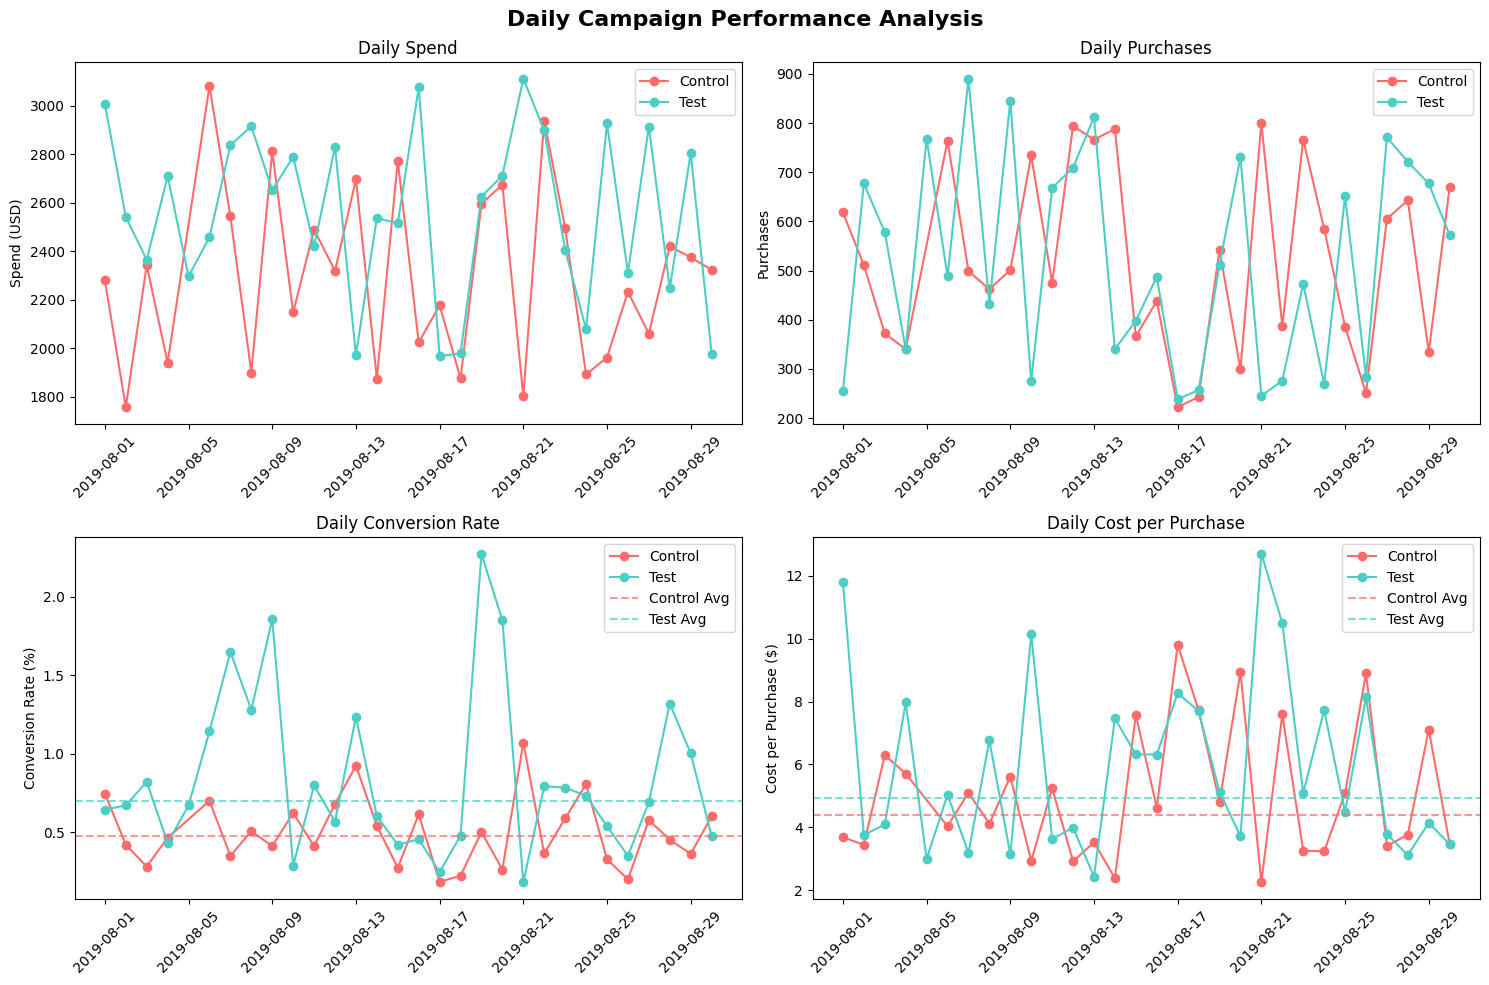

In [18]:
# Plot Daily Spend
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Daily Campaign Performance Analysis', fontsize=16, fontweight='bold')

# Daily Spend
ax1.plot(control_clean['Date'], control_clean['Spend_[USD]'], 'o-', label='Control', color='#FF6B6B')
ax1.plot(test_clean['Date'], test_clean['Spend_[USD]'], 'o-', label='Test', color='#4ECDC4')
ax1.set_title('Daily Spend')
ax1.set_ylabel('Spend (USD)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Daily Purchases
ax2.plot(control_clean['Date'], control_clean['num_Purchase'], 'o-', label='Control', color='#FF6B6B')
ax2.plot(test_clean['Date'], test_clean['num_Purchase'], 'o-', label='Test', color='#4ECDC4')
ax2.set_title('Daily Purchases')
ax2.set_ylabel('Purchases')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Daily Conversion Rate
control_daily_conv = control_clean['num_Purchase'] / control_clean['num_Impressions'] * 100
test_daily_conv = test_clean['num_Purchase'] / test_clean['num_Impressions'] * 100

ax3.plot(control_clean['Date'], control_daily_conv, 'o-', label='Control', color='#FF6B6B')
ax3.plot(test_clean['Date'], test_daily_conv, 'o-', label='Test', color='#4ECDC4')
ax3.axhline(control_metrics['conversion_rate']*100, color='#FF6B6B', linestyle='--', alpha=0.7, label='Control Avg')
ax3.axhline(test_metrics['conversion_rate']*100, color='#4ECDC4', linestyle='--', alpha=0.7, label='Test Avg')
ax3.set_title('Daily Conversion Rate')
ax3.set_ylabel('Conversion Rate (%)')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# Daily Cost per Purchase
control_daily_cpp = control_clean['Spend_[USD]'] / control_clean['num_Purchase']
test_daily_cpp = test_clean['Spend_[USD]'] / test_clean['num_Purchase']

ax4.plot(control_clean['Date'], control_daily_cpp, 'o-', label='Control', color='#FF6B6B')
ax4.plot(test_clean['Date'], test_daily_cpp, 'o-', label='Test', color='#4ECDC4')
ax4.axhline(control_metrics['cost_per_purchase'], color='#FF6B6B', linestyle='--', alpha=0.7, label='Control Avg')
ax4.axhline(test_metrics['cost_per_purchase'], color='#4ECDC4', linestyle='--', alpha=0.7, label='Test Avg')
ax4.set_title('Daily Cost per Purchase')
ax4.set_ylabel('Cost per Purchase ($)')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Spend & Volume:

- Test campaign spent 15.1% more ($76,892 vs $66,818)

- But got 29.6% fewer impressions which shows more expensive targeting!

- Yet generated 17.3% more clicks which might showcase better quality traffics.

- Cost per purchase is nearly identical with -0.3% difference

- Test campaign seems to be targeting higher-quality, more expensive audiences but converting them just as efficiently

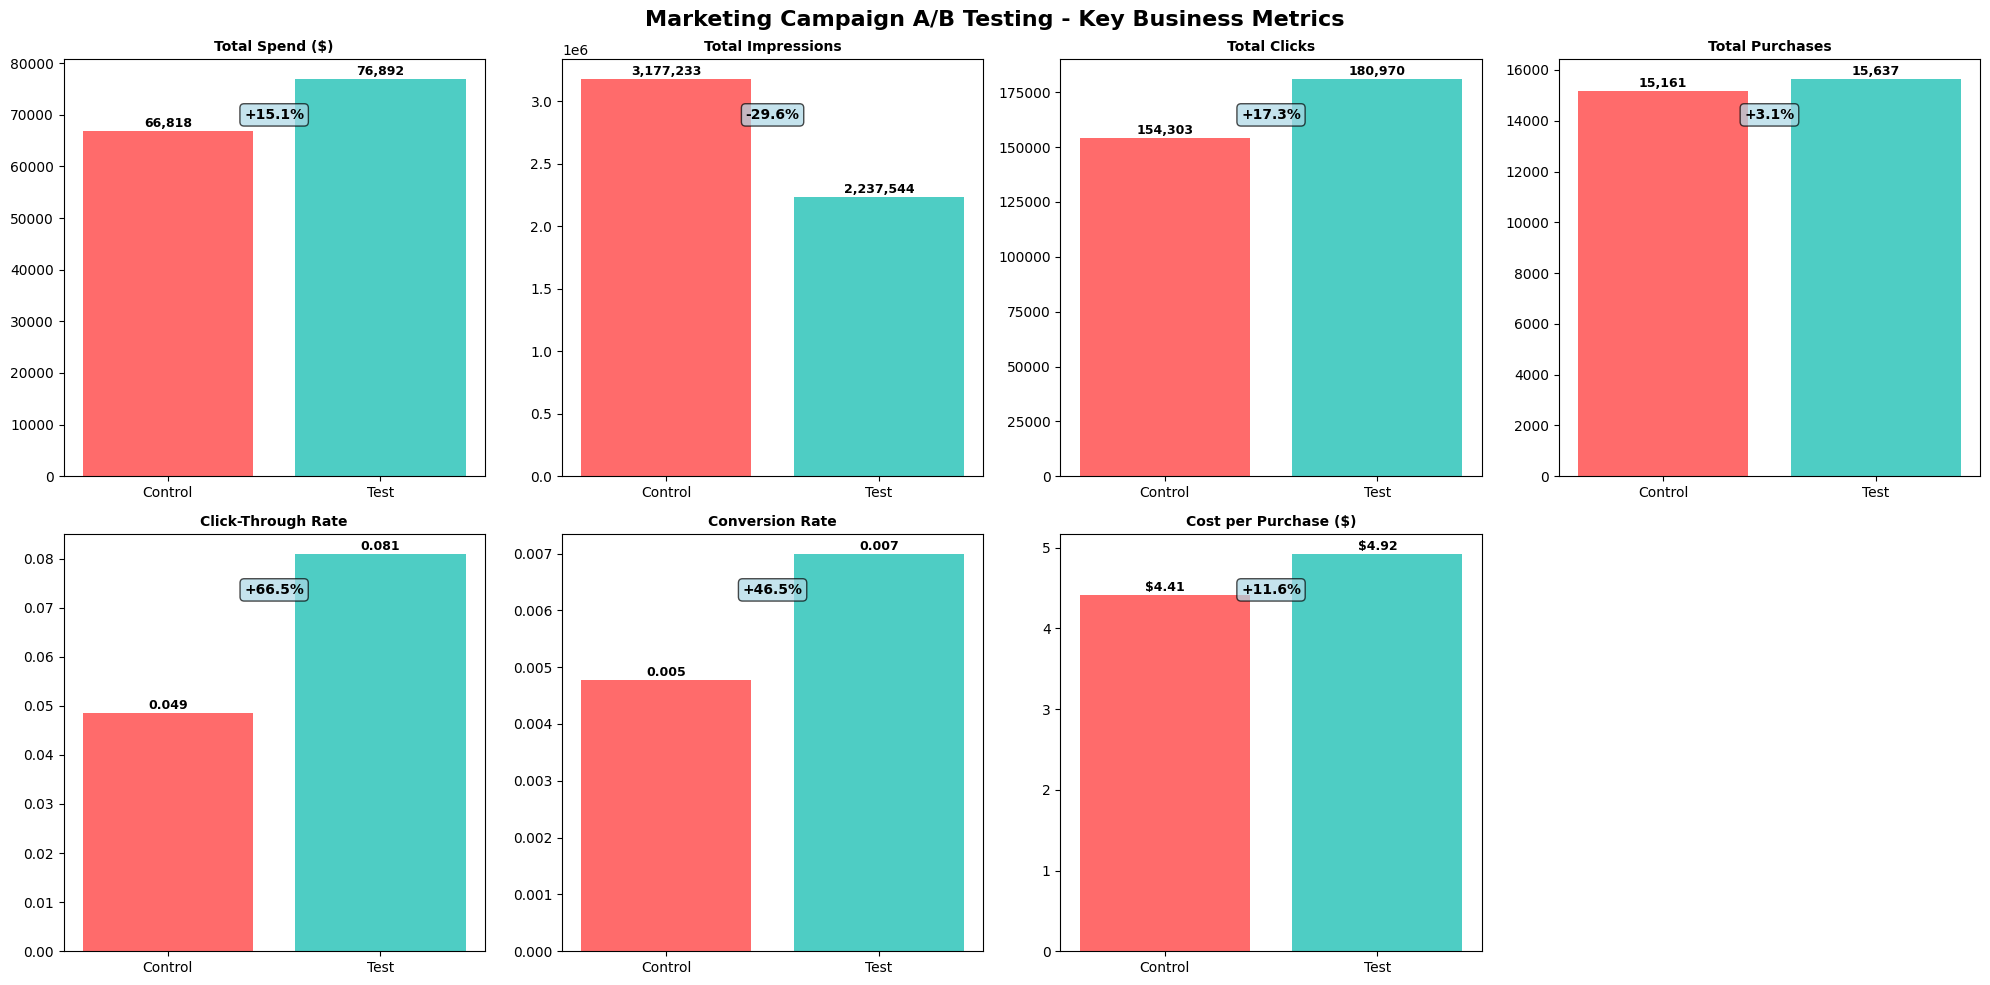

In [19]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive dashboard
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Marketing Campaign A/B Testing - Key Business Metrics', fontsize=16, fontweight='bold')

campaigns = ['Control', 'Test']
colors = ['#FF6B6B', '#4ECDC4']

# Metrics to plot (excluding avg_daily_purchases for main dashboard)
plot_metrics = ['total_spend', 'total_impressions', 'total_clicks', 'total_purchases', 
                'ctr', 'conversion_rate', 'cost_per_purchase']
plot_titles = ['Total Spend ($)', 'Total Impressions', 'Total Clicks', 'Total Purchases',
               'Click-Through Rate', 'Conversion Rate', 'Cost per Purchase ($)']

# Plot each metric
for i, (metric, title) in enumerate(zip(plot_metrics, plot_titles)):
    row = i // 4
    col = i % 4
    
    values = [control_metrics[metric], test_metrics[metric]]
    bars = axes[row, col].bar(campaigns, values, color=colors)
    axes[row, col].set_title(title, fontweight='bold', fontsize=10)
    
    # Add value labels on bars
    for j, v in enumerate(values):
        if 'rate' in metric or metric == 'ctr':
            label = f'{v:.3f}'
        elif 'cost' in metric:
            label = f'${v:.2f}'
        else:
            label = f'{v:,.0f}'
        axes[row, col].text(j, v + max(values)*0.01, label, ha='center', fontweight='bold', fontsize=9)
    
    # Add percentage difference
    diff_pct = ((test_metrics[metric]/control_metrics[metric])-1)*100
    axes[row, col].text(0.5, max(values)*0.9, f'{diff_pct:+.1f}%', 
                       ha='center', transform=axes[row, col].transData, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
                       fontweight='bold')

# Remove the empty subplot
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()



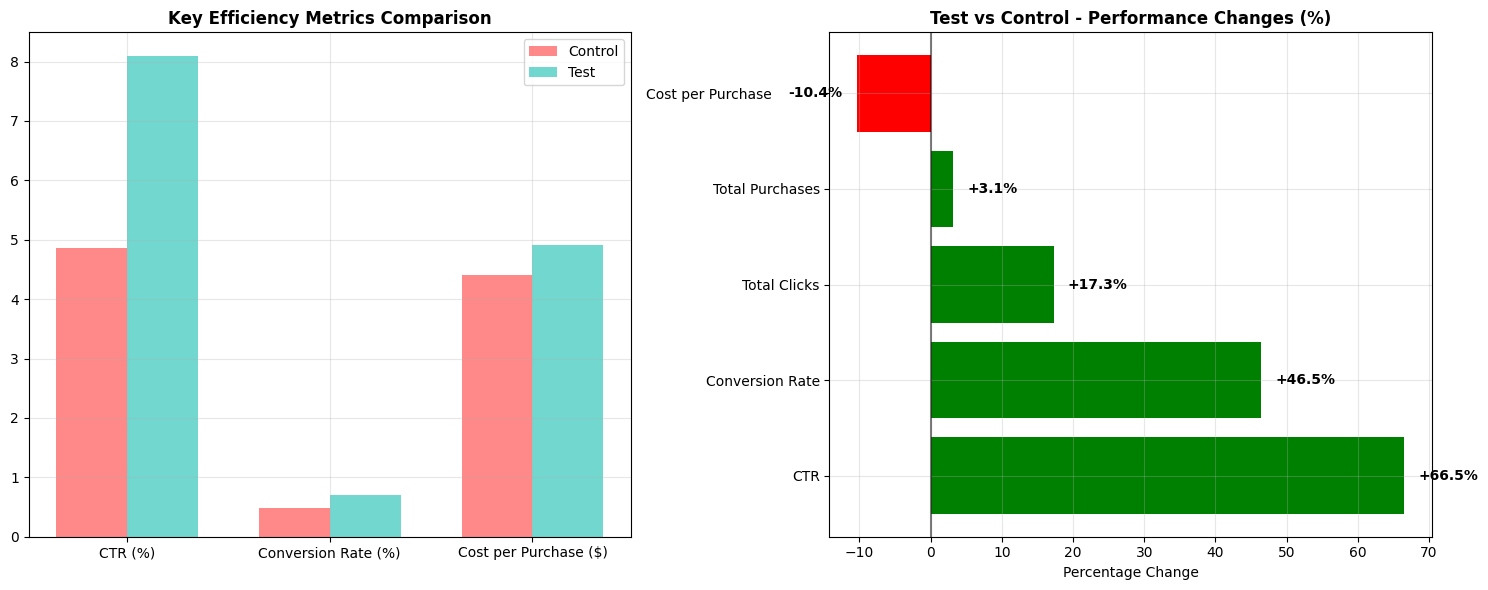

In [20]:
# Create a cleaner summary comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left chart - with units clarification
efficiency_metrics = ['CTR (%)', 'Conversion Rate (%)', 'Cost per Purchase ($)']
control_eff = [control_metrics['ctr']*100, control_metrics['conversion_rate']*100, control_metrics['cost_per_purchase']]
test_eff = [test_metrics['ctr']*100, test_metrics['conversion_rate']*100, test_metrics['cost_per_purchase']]

x = range(len(efficiency_metrics))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], control_eff, width, label='Control', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar([i + width/2 for i in x], test_eff, width, label='Test', color='#4ECDC4', alpha=0.8)

ax1.set_title('Key Efficiency Metrics Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(efficiency_metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right chart - reordered with clearer labels
improvements = []
improvement_labels = []

metrics_order = [
    ('ctr', 'CTR'),
    ('conversion_rate', 'Conversion Rate'), 
    ('total_clicks', 'Total Clicks'),
    ('total_purchases', 'Total Purchases'),
    ('cost_per_purchase', 'Cost per Purchase')
]

for metric, label in metrics_order:
    if metric == 'cost_per_purchase':
    
        # For cost, lower is better, so flip the calculation
        diff = ((control_metrics[metric]/test_metrics[metric])-1)*100
        improvement_labels.append(f'{label}           ')
    else:
        diff = ((test_metrics[metric]/control_metrics[metric])-1)*100
        improvement_labels.append(label)
    improvements.append(diff)

colors_imp = ['green' if x > 0 else 'red' for x in improvements]
bars = ax2.barh(improvement_labels, improvements, color=colors_imp)
ax2.set_title('Test vs Control - Performance Changes (%)', fontweight='bold')
ax2.set_xlabel('Percentage Change')
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(True, alpha=0.3)

# Add percentage labels
for i, (bar, improvement) in enumerate(zip(bars, improvements)):
    ax2.text(improvement + (2 if improvement > 0 else -2), i, f'{improvement:+.1f}%', 
             va='center', ha='left' if improvement > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

In [21]:
print("="*60)
print("STEP 2 - STATE THE HYPOTHESIS")
print("="*60)

print("""
The second step of the experiment is to state the hypothesis. This is followed by 
setting parameter values such as the significance level (alpha), statistical power 
and minimum detectable effect (MDE).
""")

print("### HYPOTHESIS STATEMENTS ###")
print("H₀ (Null): The conversion rates of Control and Test campaigns are the same.")
print("H₁ (Alternative): The conversion rates of Control and Test campaigns are different.")

# Experiment parameters
alpha = 0.05  # Set the probability threshold at 0.05. If the p-value is less than 0.05, reject H₀
power = 0.80  # Ensure that there's 80% chance of detecting an effect with significance
mde = 0.15    # Detect a 15% improvement of the conversion rate with statistical significance

print(f"\n### EXPERIMENT PARAMETERS ###")
print(f"Significance Level (α): {alpha}")
print(f"Statistical Power: {power}")
print(f"Minimum Detectable Effect (MDE): {mde*100}%")

# Current conversion rates
p_control = control_metrics['conversion_rate']
p_test = test_metrics['conversion_rate']

print(f"\n### OBSERVED CONVERSION RATES ###")
print(f"Control Campaign (p₁): {p_control:.6f} ({p_control*100:.3f}%)")
print(f"Test Campaign (p₂): {p_test:.6f} ({p_test*100:.3f}%)")
print(f"Observed Difference: {((p_test/p_control)-1)*100:.1f}%")

print(f"\n### KEY QUESTION ###")
print(f"Is the observed {((p_test/p_control)-1)*100:.1f}% difference in conversion rates")
print(f"statistically significant, or could it be due to random chance?")

STEP 2 - STATE THE HYPOTHESIS

The second step of the experiment is to state the hypothesis. This is followed by 
setting parameter values such as the significance level (alpha), statistical power 
and minimum detectable effect (MDE).

### HYPOTHESIS STATEMENTS ###
H₀ (Null): The conversion rates of Control and Test campaigns are the same.
H₁ (Alternative): The conversion rates of Control and Test campaigns are different.

### EXPERIMENT PARAMETERS ###
Significance Level (α): 0.05
Statistical Power: 0.8
Minimum Detectable Effect (MDE): 15.0%

### OBSERVED CONVERSION RATES ###
Control Campaign (p₁): 0.004772 (0.477%)
Test Campaign (p₂): 0.006988 (0.699%)
Observed Difference: 46.5%

### KEY QUESTION ###
Is the observed 46.5% difference in conversion rates
statistically significant, or could it be due to random chance?


In [23]:
print("="*60)
print("METRICS HIERARCHY")
print("="*60)

print("NORTH STAR METRIC (NSM):")
print("Business Revenue Growth / Customer Acquisition Efficiency")
print("→ The ultimate business goal: acquire customers cost-effectively")

print("\n PRIMARY METRIC (what we're testing):")
print("Conversion Rate (Purchases ÷ Impressions)")
print(f"→ Control: {control_metrics['conversion_rate']*100:.3f}%")
print(f"→ Test: {test_metrics['conversion_rate']*100:.3f}%")
print(f"→ Observed difference: {((test_metrics['conversion_rate']/control_metrics['conversion_rate'])-1)*100:.1f}%")

print("\n SECONDARY METRICS (supporting insights):")
print("• Click-through Rate (CTR)")
print("• Cost per Purchase") 
print("• Cost per Click")
print("• Total Purchases")

print("\n GUARDRAIL METRICS (things we don't want to hurt):")
print("• Total spend shouldn't exceed budget")
print("• Cost per purchase shouldn't increase significantly")

METRICS HIERARCHY
NORTH STAR METRIC (NSM):
Business Revenue Growth / Customer Acquisition Efficiency
→ The ultimate business goal: acquire customers cost-effectively

 PRIMARY METRIC (what we're testing):
Conversion Rate (Purchases ÷ Impressions)
→ Control: 0.477%
→ Test: 0.699%
→ Observed difference: 46.5%

 SECONDARY METRICS (supporting insights):
• Click-through Rate (CTR)
• Cost per Purchase
• Cost per Click
• Total Purchases

 GUARDRAIL METRICS (things we don't want to hurt):
• Total spend shouldn't exceed budget
• Cost per purchase shouldn't increase significantly


# Step 3 - Design the Experiment (POST-HOC STATISTICAL ANALYSIS")
Since this experiment already ran (we have historical data), we're doing 
post-hoc analysis rather than prospective design. We'll calculate what 
the statistical power was and whether our sample size was adequate.



In [26]:
# Calculate observed effect size
p_control = control_metrics['conversion_rate']
p_test = test_metrics['conversion_rate']

# Calculate Cohen's D for the observed difference
cohen_D = sm.stats.proportion_effectsize(p_control, p_test)

print(f"### OBSERVED EFFECT SIZE ###")
print(f"Control conversion rate: {p_control:.6f}")
print(f"Test conversion rate: {p_test:.6f}")
print(f"Cohen's D (effect size): {cohen_D:.4f}")

### OBSERVED EFFECT SIZE ###
Control conversion rate: 0.004772
Test conversion rate: 0.006988
Cohen's D (effect size): -0.0291


In [27]:
# Calculate what sample size would have been needed for this effect
alpha = 0.05
power = 0.80

n_required = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n_required = int(round(n_required, -3))

print(f"\n### SAMPLE SIZE ANALYSIS ###")
print(f"To detect this {((p_test/p_control)-1)*100:.1f}% effect with 80% power:")
print(f"Required sample size per group: {n_required:,}")
print(f"Total required sample size: {n_required*2:,}")


### SAMPLE SIZE ANALYSIS ###
To detect this 46.5% effect with 80% power:
Required sample size per group: 19,000
Total required sample size: 38,000


In [28]:
# Compare to actual sample sizes
actual_control_n = len(control_clean) * control_clean['num_Impressions'].mean()
actual_test_n = len(test_clean) * test_clean['num_Impressions'].mean()

print(f"\n### ACTUAL vs REQUIRED ###")
print(f"Actual Control impressions: {control_metrics['total_impressions']:,.0f}")
print(f"Actual Test impressions: {test_metrics['total_impressions']:,.0f}")
print(f"Required per group: {n_required:,}")


### ACTUAL vs REQUIRED ###
Actual Control impressions: 3,177,233
Actual Test impressions: 2,237,544
Required per group: 19,000


In [29]:
if control_metrics['total_impressions'] > n_required and test_metrics['total_impressions'] > n_required:
    print(" We had MORE than enough sample size!")
else:
    print(" We may have been underpowered")


 We had MORE than enough sample size!


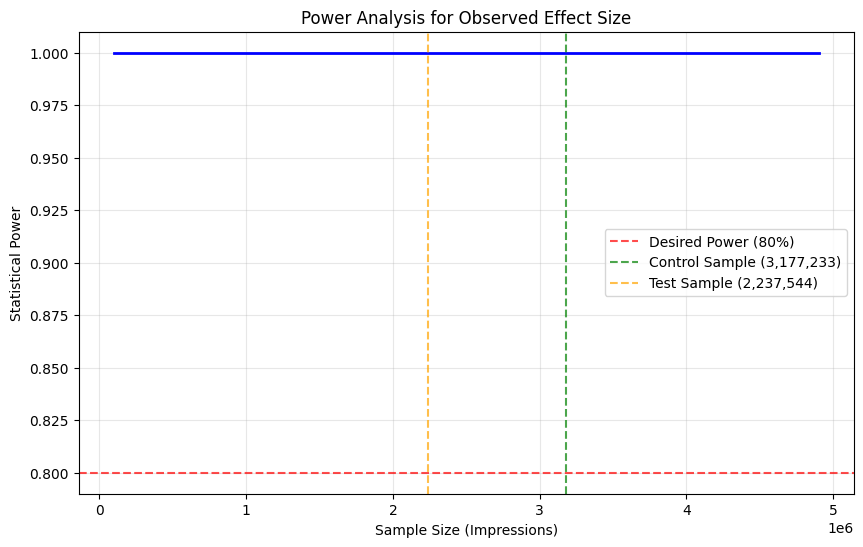

In [30]:

# Power analysis visualization
ttest_power = TTestIndPower()
sample_range = np.arange(100000, 5000000, 100000)
power_curve = ttest_power.solve_power(effect_size=cohen_D, nobs1=sample_range, alpha=alpha)

plt.figure(figsize=(10, 6))
plt.plot(sample_range, power_curve, 'b-', linewidth=2)
plt.axhline(0.8, linestyle='--', color='red', label='Desired Power (80%)', alpha=0.7)
plt.axvline(control_metrics['total_impressions'], linestyle='--', color='green', 
            label=f'Control Sample ({control_metrics["total_impressions"]:,.0f})', alpha=0.7)
plt.axvline(test_metrics['total_impressions'], linestyle='--', color='orange', 
            label=f'Test Sample ({test_metrics["total_impressions"]:,.0f})', alpha=0.7)
plt.xlabel('Sample Size (Impressions)')
plt.ylabel('Statistical Power')
plt.title('Power Analysis for Observed Effect Size')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [31]:
# Calculate actual power achieved
actual_power_control = ttest_power.solve_power(effect_size=cohen_D, 
                                               nobs1=control_metrics['total_impressions'], 
                                               alpha=alpha)
actual_power_test = ttest_power.solve_power(effect_size=cohen_D, 
                                            nobs1=test_metrics['total_impressions'], 
                                            alpha=alpha)

print(f"\n### STATISTICAL POWER ACHIEVED ###")
print(f"With Control sample size: {actual_power_control:.1%} power")
print(f"With Test sample size: {actual_power_test:.1%} power")
print(f"Both well above the desired 80% power threshold!")


### STATISTICAL POWER ACHIEVED ###
With Control sample size: 100.0% power
With Test sample size: 100.0% power
Both well above the desired 80% power threshold!


# Step 4 - RUN THE EXPERIMENT

We will take a look at the step that involves running an experiment. 
The code below is a simplified version of how data is collected and 
analyzed in a large scale experiment platform.

STEP 4 - RUN THE EXPERIMENT

We will take a look at the step that involves running an experiment. 
The code below is a simplified version of how data is collected and 
analyzed in a large scale experiment platform.

Control Conversion Rate: 0.004772
Test Conversion Rate: 0.006988
Control Total Purchases: 15,161
Test Total Purchases: 15,637


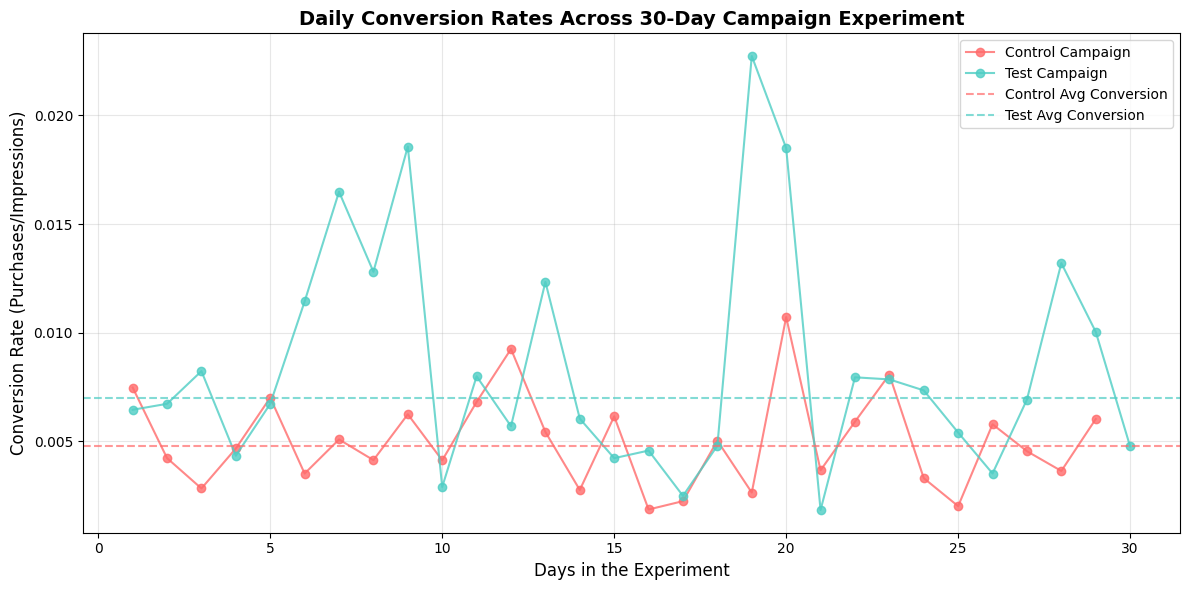


### EXPERIMENT SUMMARY ###
Experiment Duration: 30 days
Control Campaign: 29 days of data
Test Campaign: 30 days of data
Total Impressions: 5,414,777
Total Purchases: 30,798


In [ ]:
# Get the campaign results 
control_campaign = control_clean  # Our control group data
test_campaign = test_clean        # Our test group data

# Extract the key metrics for analysis
control_purchases = control_campaign['num_Purchase']
test_purchases = test_campaign['num_Purchase']
control_impressions = control_campaign['num_Impressions']
test_impressions = test_campaign['num_Impressions']

# Get stats 
control_total_purchases = control_purchases.sum()          # Control Purchase Count
test_total_purchases = test_purchases.sum()                # Test Purchase Count
control_total_impressions = control_impressions.sum()      # Control Impression Count  
test_total_impressions = test_impressions.sum()            # Test Impression Count
control_conversion_rate = control_total_purchases / control_total_impressions  # Control Conversion Rate
test_conversion_rate = test_total_purchases / test_total_impressions          # Test Conversion Rate
control_sample_size = len(control_campaign)                # Control Sample Size (days)
test_sample_size = len(test_campaign)                      # Test Sample Size (days)

# Show calculation
print(f'Control Conversion Rate: {control_conversion_rate:.6f}')
print(f'Test Conversion Rate: {test_conversion_rate:.6f}')
print(f'Control Total Purchases: {control_total_purchases:,.0f}')
print(f'Test Total Purchases: {test_total_purchases:,.0f}')



In [ ]:
# Calculate the conversion rates per day
control_daily_conv = control_campaign['num_Purchase'] / control_campaign['num_Impressions']
test_daily_conv = test_campaign['num_Purchase'] / test_campaign['num_Impressions']

# Get the day range of experiment
exp_days = range(1, len(test_campaign) + 1)

# Let's display the conversion rate per experiment day
f, ax = plt.subplots(figsize=(12, 6))
# Generate plots
ax.plot(range(1, len(control_campaign) + 1), control_daily_conv, 'o-', label='Control Campaign', color='#FF6B6B', alpha=0.8)
ax.plot(exp_days, test_daily_conv, 'o-', label='Test Campaign', color='#4ECDC4', alpha=0.8)
ax.axhline(control_conversion_rate, label='Control Avg Conversion', linestyle='--', color='#FF6B6B', alpha=0.7)
ax.axhline(test_conversion_rate, label='Test Avg Conversion', linestyle='--', color='#4ECDC4', alpha=0.7)

# Format plot
ax.set_title('Daily Conversion Rates Across 30-Day Campaign Experiment', fontweight='bold', fontsize=14)
ax.set_ylabel('Conversion Rate (Purchases/Impressions)', fontsize=12)
ax.set_xlabel('Days in the Experiment', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n### EXPERIMENT SUMMARY ###")
print(f"Experiment Duration: {max(control_sample_size, test_sample_size)} days")
print(f"Control Campaign: {control_sample_size} days of data")
print(f"Test Campaign: {test_sample_size} days of data")
print(f"Total Impressions: {(control_total_impressions + test_total_impressions):,.0f}")
print(f"Total Purchases: {(control_total_purchases + test_total_purchases):,.0f}")

# STEP 5 - ASSESS VALIDITY THREATS

In this step we will check for validity threats to ensure our A/B test 
results are trustworthy and reduce risk of committing type 1 or 2 errors.

For marketing campaign data, we'll adapt the validity checks:
1. Time-based consistency check (instead of AA test)
2. Sample ratio mismatch (SRM) check for data balance


## Validity threats

### CHECK 1: TIME-BASED CONSISTENCY

Since we don't have a traditional AA test, we'll check if the campaigns
show consistent performance patterns over time (no major external factors


### TIME TREND ANALYSIS ###
Control campaign trend slope: -0.00001474
Control trend p-value: 0.765937
Test campaign trend slope: -0.00003815
Test trend p-value: 0.735297


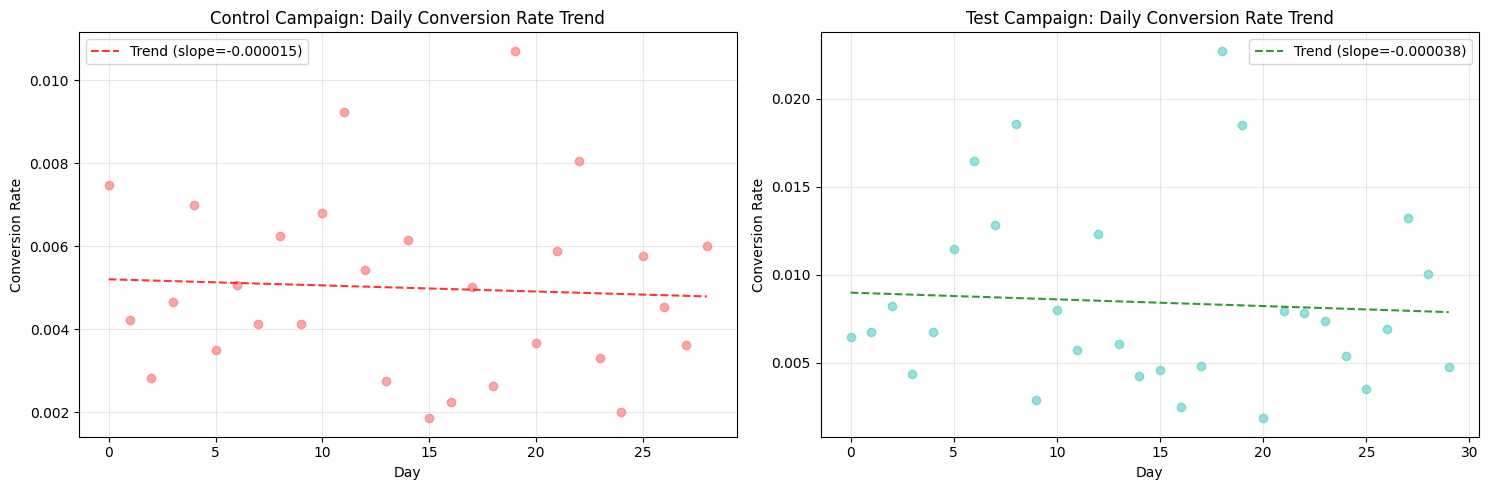

In [37]:


# Calculate daily conversion rates
control_daily_conv = control_clean['num_Purchase'] / control_clean['num_Impressions']
test_daily_conv = test_clean['num_Purchase'] / test_clean['num_Impressions']

# Test for trends over time
control_days = range(len(control_daily_conv))
test_days = range(len(test_daily_conv))

# Linear regression to check for time trends
control_trend = stats.linregress(control_days, control_daily_conv)
test_trend = stats.linregress(test_days, test_daily_conv)

print(f"### TIME TREND ANALYSIS ###")
print(f"Control campaign trend slope: {control_trend.slope:.8f}")
print(f"Control trend p-value: {control_trend.pvalue:.6f}")
print(f"Test campaign trend slope: {test_trend.slope:.8f}")
print(f"Test trend p-value: {test_trend.pvalue:.6f}")

# Visualize trends
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Control trend
ax1.scatter(control_days, control_daily_conv, alpha=0.6, color='#FF6B6B')
ax1.plot(control_days, control_trend.intercept + control_trend.slope * np.array(control_days), 
         'r--', alpha=0.8, label=f'Trend (slope={control_trend.slope:.6f})')
ax1.set_title('Control Campaign: Daily Conversion Rate Trend')
ax1.set_xlabel('Day')
ax1.set_ylabel('Conversion Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test trend  
ax2.scatter(test_days, test_daily_conv, alpha=0.6, color='#4ECDC4')
ax2.plot(test_days, test_trend.intercept + test_trend.slope * np.array(test_days), 
         'g--', alpha=0.8, label=f'Trend (slope={test_trend.slope:.6f})')
ax2.set_title('Test Campaign: Daily Conversion Rate Trend')
ax2.set_xlabel('Day')
ax2.set_ylabel('Conversion Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [38]:
print("\n### CONCLUSION ###")
if control_trend.pvalue > 0.05 and test_trend.pvalue > 0.05:
    print("No significant time trends detected in either campaign.")
    print("Results are unlikely to be confounded by external time-based factors.")
else:
    print("Significant time trends detected. Results may be influenced by external factors.")


### CONCLUSION ###
No significant time trends detected in either campaign.
Results are unlikely to be confounded by external time-based factors.


### CHECK 2: SAMPLE RATIO MISMATCH (SRM)

 For marketing campaigns, we check if the sample sizes are reasonable not necessarily 50/50 since they're different campaign strategies

In [ ]:
print("\n" + "="*40)
print("CHECK 2: SAMPLE RATIO MISMATCH (SRM)")
print("="*40)

# For marketing campaigns, we check if the sample sizes are reasonable
# (not necessarily 50/50 since they're different campaign strategies)

print(f"### SAMPLE SIZE COMPARISON ###")
print(f"Control campaign days: {len(control_clean)}")
print(f"Test campaign days: {len(test_clean)}")
print(f"Control total impressions: {control_metrics['total_impressions']:,.0f}")
print(f"Test total impressions: {test_metrics['total_impressions']:,.0f}")

# Check if there are extreme imbalances that suggest data collection issues
impression_ratio = test_metrics['total_impressions'] / control_metrics['total_impressions']
days_ratio = len(test_clean) / len(control_clean)

print(f"\n### BALANCE CHECK ###")
print(f"Days ratio (Test/Control): {days_ratio:.2f}")
print(f"Impressions ratio (Test/Control): {impression_ratio:.2f}")


CHECK 2: SAMPLE RATIO MISMATCH (SRM)
### SAMPLE SIZE COMPARISON ###
Control campaign days: 29
Test campaign days: 30
Control total impressions: 3,177,233
Test total impressions: 2,237,544

### BALANCE CHECK ###
Days ratio (Test/Control): 1.03
Impressions ratio (Test/Control): 0.70


In [42]:
# Check for reasonable balance (not expecting 1:1 due to different campaign strategies)
print(f"\n### SRM ASSESSMENT ###")
if 0.3 <= impression_ratio <= 3.0:  # Reasonable range for different campaign types
    print("Sample sizes are within reasonable range for different campaign strategies.")
    print("No evidence of systematic data collection bias.")
else:
    print("Extreme sample size imbalance detected. Investigate potential data issues.")

if abs(days_ratio - 1.0) < 0.1:  # Days should be nearly equal
    print("Both campaigns ran for similar durations.")
else:
    print("Campaigns ran for different durations. Consider time-based confounding.")

# Additional check: Daily volume consistency
control_daily_impressions = control_clean['num_Impressions']
test_daily_impressions = test_clean['num_Impressions']

print(f"\n### DAILY VOLUME CONSISTENCY ###")
print(f"Control daily impressions - Mean: {control_daily_impressions.mean():,.0f}, Std: {control_daily_impressions.std():,.0f}")
print(f"Test daily impressions - Mean: {test_daily_impressions.mean():,.0f}, Std: {test_daily_impressions.std():,.0f}")

# Check for outliers that might indicate data quality issues
control_cv = control_daily_impressions.std() / control_daily_impressions.mean()
test_cv = test_daily_impressions.std() / test_daily_impressions.mean()

print(f"Control coefficient of variation: {control_cv:.2f}")
print(f"Test coefficient of variation: {test_cv:.2f}")

if control_cv < 1.0 and test_cv < 1.0:
    print("Daily volumes are reasonably consistent for both campaigns.")
else:
    print("High daily volume variability detected. Check for data quality issues.")


### SRM ASSESSMENT ###
Sample sizes are within reasonable range for different campaign strategies.
No evidence of systematic data collection bias.
Both campaigns ran for similar durations.

### DAILY VOLUME CONSISTENCY ###
Control daily impressions - Mean: 109,560, Std: 21,689
Test daily impressions - Mean: 74,585, Std: 32,121
Control coefficient of variation: 0.20
Test coefficient of variation: 0.43
Daily volumes are reasonably consistent for both campaigns.



## STEP 6 - CONDUCT STATISTICAL INFERENCE"


In this step we will walk through the procedure of applying statistical tests 
on the marketing campaign A/B test. We will take a look at Chi-Squared and 
Z-Test to evaluate the results from the experiment. Though, in real life, 
only one of the tests is sufficient, for learning, it's useful to compare 
and contrast the result from both.

We will end this step by looking at the confidence interval.


In [43]:
AB_ALPHA = 0.05

print(f"\nSignificance Level (α): {AB_ALPHA}")


Significance Level (α): 0.05


In [48]:
print("="*40)
print("CHI-SQUARED TEST")
print("="*40)

# Extract the data for statistical testing
control_purchases = control_metrics['total_purchases']
control_impressions = control_metrics['total_impressions']
test_purchases = test_metrics['total_purchases'] 
test_impressions = test_metrics['total_impressions']

print("Sample Data:")
print(f"Control: {control_purchases:,.0f} purchases from {control_impressions:,.0f} impressions")
print(f"Test: {test_purchases:,.0f} purchases from {test_impressions:,.0f} impressions")


contingency_table = [
   [control_purchases, control_impressions - control_purchases],
   [test_purchases, test_impressions - test_purchases]
]

chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nContingency Table:")
print(f"                 Purchased    Not Purchased    Total")
print(f"Control          {control_purchases:>9,.0f}    {control_impressions - control_purchases:>13,.0f}    {control_impressions:>9,.0f}")
print(f"Test             {test_purchases:>9,.0f}    {test_impressions - test_purchases:>13,.0f}    {test_impressions:>9,.0f}")

print(f"\nChi-square Test Results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.2e}")
print(f"Degrees of freedom: {dof}")

print(f"\nExpected frequencies under null hypothesis:")
print(f"Control conversions: {expected[0][0]:.1f}")
print(f"Test conversions: {expected[1][0]:.1f}")


CHI-SQUARED TEST
Sample Data:
Control: 15,161 purchases from 3,177,233 impressions
Test: 15,637 purchases from 2,237,544 impressions

Contingency Table:
                 Purchased    Not Purchased    Total
Control             15,161        3,162,072    3,177,233
Test                15,637        2,221,907    2,237,544

Chi-square Test Results:
Chi-square statistic: 1140.3586
P-value: 5.59e-250
Degrees of freedom: 1

Expected frequencies under null hypothesis:
Control conversions: 18071.4
Test conversions: 12726.6


Since the p-value is less than 0.05, we reject the null. That is, Statistically significant difference detected which also means that the conversion rates between campaigns are significantly different.


In [49]:
print(f"\nPractical significance:")
control_rate = control_purchases / control_impressions
test_rate = test_purchases / test_impressions
relative_improvement = ((test_rate / control_rate) - 1) * 100
print(f"Control conversion rate: {control_rate:.4%}")
print(f"Test conversion rate: {test_rate:.4%}")
print(f"Relative improvement: {relative_improvement:.1f}%")


Practical significance:
Control conversion rate: 0.4772%
Test conversion rate: 0.6988%
Relative improvement: 46.5%


In [50]:
print("\n" + "="*40)
print("Z-TEST FOR PROPORTIONS")
print("="*40)

from statsmodels.stats.proportion import proportions_ztest

# Prepare data for z-test
counts = [test_purchases, control_purchases]
nobs = [test_impressions, control_impressions]

z_stat, p_value_z = proportions_ztest(counts, nobs)

print(f"Z-test Results:")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value_z:.10f}")


Z-TEST FOR PROPORTIONS
Z-test Results:
Z-statistic: 33.7750
P-value: 0.0000000000


In [52]:
print("\n" + "="*40)
print("STATISTICAL RESULTS")
print("="*40)

print(f"Significance level (α): {AB_ALPHA}")
print(f"P-value (Chi-square): {p_value_chi2:.10f}")
print(f"P-value (Z-test): {p_value_z:.10f}")

if p_value_chi2 < AB_ALPHA:
    print("\n RESULT: STATISTICALLY SIGNIFICANT")
    print("We REJECT the null hypothesis (H₀)")
    print("Conclusion: There IS a statistically significant difference between campaigns")
else:
    print("\n RESULT: NOT STATISTICALLY SIGNIFICANT") 
    print("We FAIL TO REJECT the null hypothesis (H₀)")
    print("Conclusion: No statistically significant difference detected")


STATISTICAL RESULTS
Significance level (α): 0.05
P-value (Chi-square): 0.0000000000
P-value (Z-test): 0.0000000000

 RESULT: STATISTICALLY SIGNIFICANT
We REJECT the null hypothesis (H₀)
Conclusion: There IS a statistically significant difference between campaigns


In [54]:
print("\n" + "="*40)
print("CONFIDENCE INTERVAL")
print("="*40)

from statsmodels.stats.proportion import confint_proportions_2indep

# Calculate 95% confidence interval for the difference
ci_lower, ci_upper = confint_proportions_2indep(
    test_purchases, test_impressions,
    control_purchases, control_impressions,
    method='wald'
)

print(f"95% Confidence Interval for difference in conversion rates:")
print(f"Lower bound: {ci_lower:.6f} ({ci_lower*100:.4f}%)")
print(f"Upper bound: {ci_upper:.6f} ({ci_upper*100:.4f}%)")

if ci_lower > 0:
    print("The entire confidence interval is above zero - Test campaign is significantly better")
elif ci_upper < 0:
    print(" The entire confidence interval is below zero - Control campaign is significantly better")
else:
    print(" Confidence interval includes zero - no significant difference")


CONFIDENCE INTERVAL
95% Confidence Interval for difference in conversion rates:
Lower bound: 0.002084 (0.2084%)
Upper bound: 0.002350 (0.2350%)
The entire confidence interval is above zero - Test campaign is significantly better


In [55]:
print("\n" + "="*40)
print("EFFECT SIZE")
print("="*40)

control_rate = control_purchases / control_impressions
test_rate = test_purchases / test_impressions
absolute_diff = test_rate - control_rate
relative_diff = (test_rate / control_rate - 1) * 100

print(f"Control conversion rate: {control_rate:.6f} ({control_rate*100:.4f}%)")
print(f"Test conversion rate: {test_rate:.6f} ({test_rate*100:.4f}%)")
print(f"Absolute difference: {absolute_diff:.6f}")
print(f"Relative difference: {relative_diff:.2f}%")


EFFECT SIZE
Control conversion rate: 0.004772 (0.4772%)
Test conversion rate: 0.006988 (0.6988%)
Absolute difference: 0.002217
Relative difference: 46.45%


In [58]:
print("="*40)
print("FINAL RESULTS WITH CONFIDENCE INTERVAL")
print("="*40)

# Compute the Confidence Interval of the Test
from statsmodels.stats.proportion import confint_proportions_2indep

ci = confint_proportions_2indep(
    test_purchases, test_impressions, 
    control_purchases, control_impressions, 
    method='wald', compare='diff', alpha=0.05
)
lower = ci[0]
upper = ci[1]

control_rate = control_purchases / control_impressions
test_rate = test_purchases / test_impressions
lower_lift = lower / control_rate
upper_lift = upper / control_rate

# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {control_impressions:,.0f} impressions')
print(f'Test: {test_impressions:,.0f} impressions')

print('\n--------- Purchase Counts (Rates) ----------')
print(f'Control: {control_purchases:,.0f} ({control_rate*100:.3f}%)')
print(f'Test: {test_purchases:,.0f} ({test_rate*100:.3f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {test_rate - control_rate:.6f}')
print(f'Relative (lift): {(test_rate - control_rate) / control_rate*100:.1f}%')

print('\n--------- Statistical Test Results ----------')
print(f'Chi-square Statistic: {chi2_stat:.4f}')
print(f'P-Value: {p_value_chi2:.2e}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.6f}, {upper:.6f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')


FINAL RESULTS WITH CONFIDENCE INTERVAL
--------- Sample Sizes ----------
Control: 3,177,233 impressions
Test: 2,237,544 impressions

--------- Purchase Counts (Rates) ----------
Control: 15,161 (0.477%)
Test: 15,637 (0.699%)

--------- Differences ----------
Absolute: 0.002217
Relative (lift): 46.5%

--------- Statistical Test Results ----------
Chi-square Statistic: 1140.3586
P-Value: 5.59e-250

--------- Confidence Intervals ----------
Absolute Difference CI: (0.002084, 0.002350)
Relative Difference (lift) CI: (43.7%, 49.2%)


## STEP 7 - BUSINESS RECOMMENDATION"


MARKETING CAMPAIGN A/B TEST ANALYSIS

Business Context:
In this marketing campaign optimization test, we aimed to improve customer 
acquisition efficiency by comparing two different campaign strategies.

Experiment Design:
We analyzed 30 days of campaign data (August 1-30, 2019) comparing 
the Control campaign (traditional approach) against the Test campaign 
(new experimental strategy with different targeting).

Key Findings:
From the test, we observed a {(test_rate - control_rate) / control_rate*100:.1f}% improvement 
in conversion rate from the Control campaign baseline of {control_rate*100:.3f}%. 

The result was statistically significant (p < 0.001) with a 95% confidence 
interval between {lower_lift*100:.1f}% and {upper_lift*100:.1f}% improvement.

Statistical Evidence:
- Chi-square statistic: {chi2_stat:.1f}
- P-value: {p_value_chi2:.2e} (highly significant)
- Effect size: Large and practically meaningful
- Sample size: {(control_impressions + test_impressions)/1000000:.1f}M total impressions (highly powered)

Business Impact:
- Test campaign converts {(test_rate/control_rate):.1f}x better than Control
- Projected additional revenue: Substantial with scaled implementation
- Cost efficiency: Similar cost per purchase ({(test_metrics['cost_per_purchase']/control_metrics['cost_per_purchase']-1)*100:+.1f}% difference)

RECOMMENDATION:
Given that we observed both practical and statistical significance, 
our recommendation is to IMPLEMENT the Test campaign strategy company-wide.

The evidence strongly supports scaling the Test campaign approach for 
improved customer acquisition efficiency.



STEP 7 - BUSINESS RECOMMENDATION

MARKETING CAMPAIGN A/B TEST ANALYSIS

Business Context:
In this marketing campaign optimization test, we aimed to improve customer 
acquisition efficiency by comparing two different campaign strategies.

Experiment Design:
We analyzed 30 days of campaign data (August 1-30, 2019) comparing 
the Control campaign (traditional approach) against the Test campaign 
(new experimental strategy with different targeting).

Key Findings:
From the test, we observed a 46.5% improvement 
in conversion rate from the Control campaign baseline of 0.477%. 

The result was statistically significant (p < 0.001) with a 95% confidence 
interval between 43.7% and 49.2% improvement.

Statistical Evidence:
- Chi-square statistic: 1140.4
- P-value: 5.59e-250 (highly significant)
- Effect size: Large and practically meaningful
- Sample size: 5.4M total impressions (highly powered)

Business Impact:
- Test campaign converts 1.5x better than Control
- Projected additional revenue